In [80]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.utils import save_image

In [81]:
if (os.path.exists("./data")) == False:
    os.mkdir("data")

In [82]:
dir_pokemon = "./archive/pokemon"
files_pokemon = os.listdir(dir_pokemon + '/pokemon')

In [83]:
transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])


batch_size = 350

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = ImageFolder(root = dir_pokemon, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last = True)

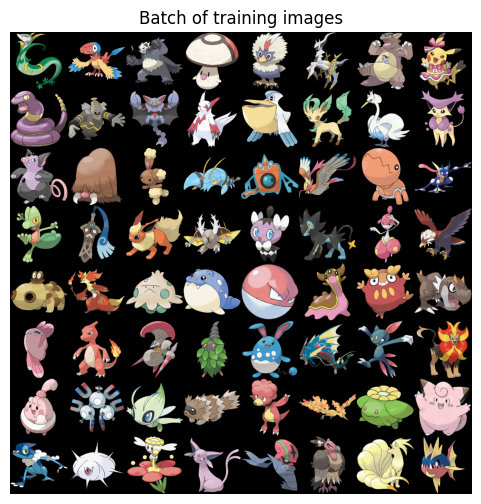

In [84]:
first_batch = next(iter(dataloader))
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Batch of training images")
plt.imshow(vutils.make_grid(first_batch[0][:64], padding=2, normalize=True).cpu().numpy().transpose(1,2,0))
plt.show()

In [85]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

In [86]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np  # Corrected alias for clarity

class Discriminator(nn.Module):
    def __init__(self, input_size=(3, 256, 256)):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_size[0], 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # Ensure the output size matches your expectations
        )

        # Use a method to dynamically calculate the flattened size
        self.flatten_size = self._get_flatten_size(input_size)

        print(self.flatten_size)  # Add this print statement
        self.fc = nn.Linear(self.flatten_size, 1)

      # Dynamically set in_features based on the actual output
        self.sigmoid = nn.Sigmoid()

    def _get_flatten_size(self, input_size):
        dummy_input = torch.zeros(1, *input_size)
        dummy_output = self.conv_layers(dummy_input)
        return int(np.prod(dummy_output.size()[1:]))  # Calculate the product of dimensions excluding the batch dimension.


    def forward(self, input):
        x = self.conv_layers(input)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        x = self.sigmoid(x)
        return x.view(-1, 1)


In [88]:
first_batch = next(iter(dataloader))
image, image_label = first_batch[0].to(device), first_batch[1].to(device)

discriminator = Discriminator()
discriminator.to(device)

output = discriminator(image)

print(output.size())

131072
torch.Size([350, 1])


In [89]:
noise = torch.randn(batch_size, 128, 1, 1, device=device)
generator = Generator()
generator.to(device)

fake_image = generator(noise)
print(fake_image.size())

torch.Size([350, 3, 64, 64])


# Train

In [90]:
criterion = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

generator.apply(weights_init)
discriminator.apply(weights_init)

generator.to(device)
discriminator.to(device)

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 1000

131072


In [91]:
# Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        image, image_label = data[0].to(device), data[1].to(device)

        # Train discriminator
        discriminator.zero_grad()
        real_label = 0.9  # instead of 1, use 0.9 for label smoothing
        fake_label = 0
        
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        output = discriminator(image).view(-1)

        loss_discriminator_real = criterion(output, label)
        loss_discriminator_real.backward()

        noise = torch.randn(batch_size, 128, 1, 1, device=device)
        fake_image = generator(noise)
        label.fill_(0)

        output = discriminator(fake_image.detach()).view(-1)

        loss_discriminator_fake = criterion(output, label)
        loss_discriminator_fake.backward()

        errD = loss_discriminator_real + loss_discriminator_fake
        optimizerD.step()

        # Train generator
        generator.zero_grad()
        label.fill_(1)
        output = discriminator(fake_image).view(-1)

        loss_generator = criterion(output, label)
        loss_generator.backward()
        optimizerG.step()

    if (epoch % 10 == 0):
        with torch.no_grad():
            fixed_noise = torch.randn(64, 128, 1, 1, device=device)
            fake_images = generator(fixed_noise).detach().cpu()
            loss_on_real = loss_discriminator_real.detach().cpu()
            loss_on_fake = loss_discriminator_fake.detach().cpu()

        print(f'epoch: {epoch}, loss on real: {loss_on_real}, loss on fake: {loss_on_fake}')

        save_image(fake_images, f'./data/fake_images_epoch_{epoch:04d}.png', nrow=8, normalize=True)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (350x8192 and 131072x1)